Iniciando análisis de regresión y proyecciones...

--- 1. Cargando y preparando datos ---
Datos unidos listos para regresión.

--- 2. Regresión Lineal y Polinomial (PIB vs Exp. de Vida) ---
Regresión Lineal (Log-PIB vs Vida): R²: 0.263
Regresión Polinomial (Grado 3, Log-PIB vs Vida): R²: 0.296


c:\Users\gasxd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\gasxd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


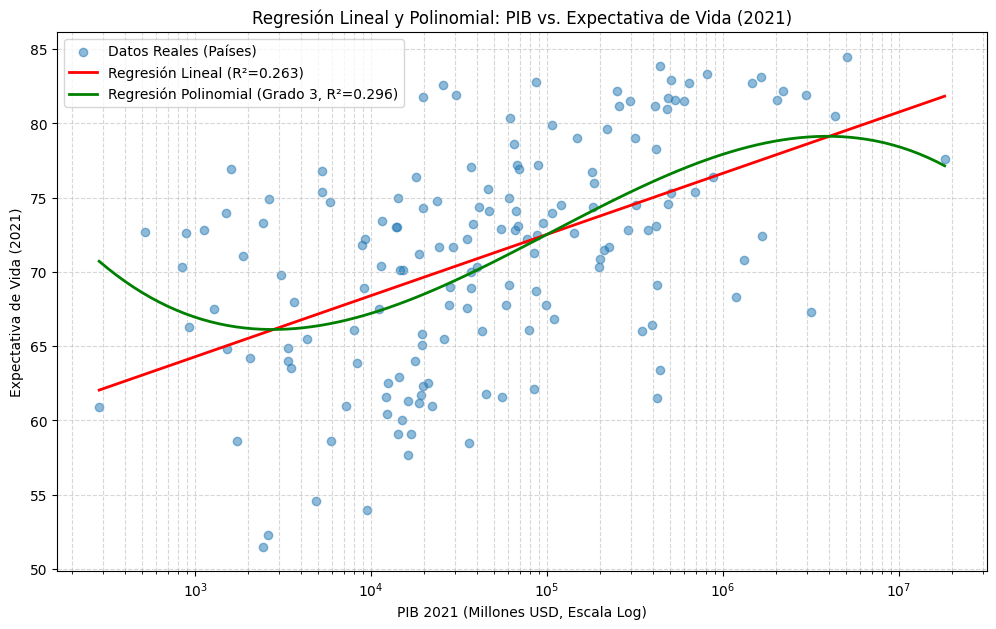

Gráfico de regresión (PIB vs Exp. Vida) guardado.

--- 3. Proyección Lineal (Series Temporales del PIB) ---
Modelo de proyección lineal para 'Germany' (PIB vs Año): R²: 0.855


c:\Users\gasxd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


<Figure size 640x480 with 0 Axes>

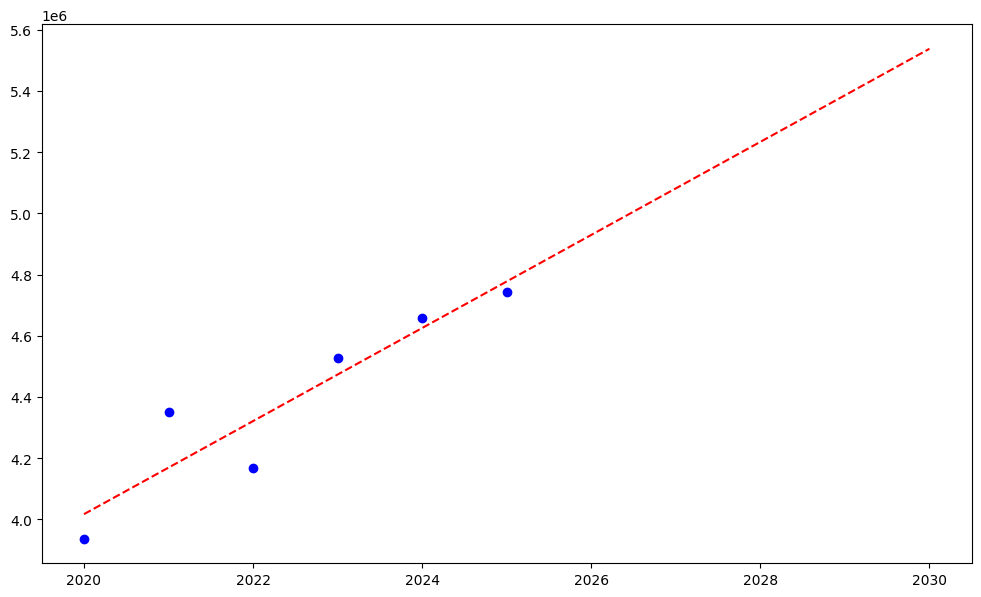

Gráfico de proyección (PIB Germany) guardado.

Análisis de regresión y proyecciones completado.


C:\Users\gasxd\AppData\Local\Temp\ipykernel_21996\3677181315.py:145: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 640x480 with 0 Axes>

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

print("Iniciando análisis de regresión y proyecciones...")

try:
    # --- Tarea 1: Carga y Limpieza de Datos ---
    print("\n--- 1. Cargando y preparando datos ---")
    
    # Cargar los datasets
    pib_df = pd.read_csv("data_2025/pib2020-2025.csv")
    who_df = pd.read_csv("data_2025/WHO_life_expectancy.csv")

    # 1.1 Limpiar datos de Expectativa de Vida (WHO)
    # Extraer el valor numérico principal
    who_df['Life_Expectancy'] = who_df['Value'].astype(str).str.extract(r"(\d+\.?\d*)").astype(float)
    # Filtrar por indicador, sexo y año
    who_df_filtered = who_df[
        (who_df['Indicator'] == 'Life expectancy at birth (years)') &
        (who_df['Dim1'] == 'Both sexes')
    ]
    who_df_2021 = who_df_filtered[who_df_filtered['Period'] == 2021].copy()
    life_exp_2021 = who_df_2021[['Location', 'Life_Expectancy']].rename(columns={'Location': 'Country'})
    life_exp_2021 = life_exp_2021.dropna()

    # 1.2 Limpiar datos del PIB (PIB)
    pib_df['2021_numeric'] = pd.to_numeric(pib_df['2021'], errors='coerce')
    gdp_2021 = pib_df[['Country', '2021_numeric']].rename(columns={'2021_numeric': 'GDP_2021'})
    gdp_2021 = gdp_2021.dropna()

    # 1.3 Unir los DataFrames
    merged_df = pd.merge(gdp_2021, life_exp_2021, on='Country', how='inner')
    merged_df = merged_df.dropna()
    print("Datos unidos listos para regresión.")

    # --- Tarea 2: Regresión Lineal y Polinomial (PIB vs Expectativa de Vida) ---
    print("\n--- 2. Regresión Lineal y Polinomial (PIB vs Exp. de Vida) ---")

    # Preparar datos:
    # Filtrar GDP > 0 para poder aplicar el logaritmo
    valid_data = merged_df[merged_df['GDP_2021'] > 0].copy()
    # 'X' (variable independiente) debe ser un DataFrame 2D
    X = valid_data[['GDP_2021']] 
    # 'y' (variable dependiente)
    y = valid_data['Life_Expectancy']
    
    # Usamos el logaritmo del PIB para X, ya que la relación no es lineal
    X_log = np.log(X)

    # 2.1 Modelo de Regresión Lineal (sobre X_log)
    lin_reg = LinearRegression()
    lin_reg.fit(X_log, y)
    y_pred_lin = lin_reg.predict(X_log)
    lin_r2 = r2_score(y, y_pred_lin)
    print(f"Regresión Lineal (Log-PIB vs Vida): R²: {lin_r2:.3f}")

    # 2.2 Modelo de Regresión Polinomial (Grado 3)
    # Crear características polinomiales (X^1, X^2, X^3)
    poly_features = PolynomialFeatures(degree=3, include_bias=False)
    X_poly = poly_features.fit_transform(X_log)
    
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly, y)
    y_pred_poly = poly_reg.predict(X_poly)
    poly_r2 = r2_score(y, y_pred_poly)
    print(f"Regresión Polinomial (Grado 3, Log-PIB vs Vida): R²: {poly_r2:.3f}")

    # 2.3 Visualización de Regresiones
    plt.figure(figsize=(12, 7))
    plt.scatter(X, y, alpha=0.5, label='Datos Reales (Países)')
    plt.xscale('log') # Escala logarítmica para el eje X
    
    # Crear puntos ordenados para trazar las líneas de regresión
    X_plot = np.logspace(np.log10(X['GDP_2021'].min()), np.log10(X['GDP_2021'].max()), 100)
    X_plot_log = np.log(X_plot.reshape(-1, 1))
    
    # Predecir para la línea lineal
    y_plot_lin = lin_reg.predict(X_plot_log)
    plt.plot(X_plot, y_plot_lin, color='red', linewidth=2, label=f'Regresión Lineal (R²={lin_r2:.3f})')
    
    # Predecir para la curva polinomial
    # Transformamos los puntos de ploteo usando las mismas características polinomiales
    y_plot_poly = poly_reg.predict(poly_features.transform(X_plot_log))
    plt.plot(X_plot, y_plot_poly, color='green', linewidth=2, label=f'Regresión Polinomial (Grado 3, R²={poly_r2:.3f})')

    plt.title('Regresión Lineal y Polinomial: PIB vs. Expectativa de Vida (2021)')
    plt.xlabel('PIB 2021 (Millones USD, Escala Log)')
    plt.ylabel('Expectativa de Vida (2021)')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()
    plt.savefig('regression_gdp_life_exp.png')
    print("Gráfico de regresión (PIB vs Exp. Vida) guardado.")
    plt.clf()


    # --- Tarea 3: Proyección Lineal (Series Temporales del PIB) ---
    print("\n--- 3. Proyección Lineal (Series Temporales del PIB) ---")
    
    # Recargar pib_df para asegurar datos limpios
    pib_df_ts = pd.read_csv("data_2025/pib2020-2025.csv")
    
    # Preparar datos (melt)
    year_cols = ['2020', '2021', '2022', '2023', '2024', '2025']
    for col in year_cols:
        pib_df_ts[col] = pd.to_numeric(pib_df_ts[col], errors='coerce')
        
    pib_melted = pib_df_ts.melt(id_vars=['Country'], value_vars=year_cols, var_name='Year', value_name='GDP')
    pib_melted['Year'] = pd.to_numeric(pib_melted['Year'])
    pib_melted = pib_melted.dropna()

    # Elegir un país para la proyección, ej: 'Germany'
    country_name = 'Germany'
    country_data = pib_melted[pib_melted['Country'] == country_name]

    if not country_data.empty:
        # Preparar datos para sklearn (X debe ser 2D)
        X_time = country_data[['Year']]
        y_time = country_data['GDP']

        # Crear y entrenar el modelo de regresión lineal
        time_reg = LinearRegression()
        time_reg.fit(X_time, y_time)
        time_r2 = time_reg.score(X_time, y_time) # Calcular R²
        print(f"Modelo de proyección lineal para '{country_name}' (PIB vs Año): R²: {time_r2:.3f}")

        # Crear años para la proyección (ej. hasta 2030)
        years_to_project = np.array(range(X_time['Year'].min(), 2031)).reshape(-1, 1)
        gdp_projection = time_reg.predict(years_to_project)

        # 3.2 Visualización de la Proyección
        plt.figure(figsize=(12, 7))
        plt.scatter(X_time, y_time, label=f'Datos Reales ({country_name})', color='blue')
        plt.plot(years_to_project, gdp_projection, color='red', linestyle='--', label=f'Proyección Lineal (R²={time_r2:.3f})')
        plt.show()
        
        plt.title(f'Proyección Lineal del PIB para {country_name} (2020-2030)')
        plt.xlabel('Año')
        plt.ylabel('PIB (Millones USD)')
        plt.legend()
        plt.grid(True, ls="--", alpha=0.5)
        plt.savefig('projection_gdp_germany.png')
        print(f"Gráfico de proyección (PIB {country_name}) guardado.")
        plt.clf()
    else:
        print(f"No se encontraron datos para el país '{country_name}'.")

    print("\nAnálisis de regresión y proyecciones completado.")

except Exception as e:
    print(f"Ocurrió un error: {e}")

In [31]:
merged_df.head()

,Country,GDP_2021,Life_Expectancy,ParentLocation,Log_GDP
0,Afghanistan,14278.0,59.1,Eastern Mediterranean,9.566475
1,Albania,18086.0,76.4,Europe,9.802893
2,Algeria,185850.0,76.0,Africa,12.132695
3,Angola,84375.0,62.1,Africa,11.343026
4,Antigua and Barbuda,1602.0,76.9,Americas,7.379008


Limpieza de datos

In [5]:
import pandas as pd
import re

# --- Carga de Datos ---
pib_df = pd.read_csv("data_2025/pib2020-2025.csv")
who_df = pd.read_csv("data_2025/WHO_life_expectancy.csv")

# --- 1.1 Limpiar datos de Expectativa de Vida (WHO) ---
# Extraer el valor numérico de la columna 'Value'
who_df['Life_Expectancy'] = who_df['Value'].astype(str).str.extract(r"(\d+\.?\d*)").astype(float)

# Filtrar para 'Life expectancy at birth (years)', 'Both sexes', y '2021'
who_df_filtered = who_df[
    (who_df['Indicator'] == 'Life expectancy at birth (years)') &
    (who_df['Dim1'] == 'Both sexes')
]
who_df_2021 = who_df_filtered[who_df_filtered['Period'] == 2021].copy()

# Seleccionar y renombrar columnas
life_exp_2021 = who_df_2021[['Location', 'Life_Expectancy']].rename(columns={'Location': 'Country'})
life_exp_2021 = life_exp_2021.dropna()

# --- 1.2 Limpiar datos del PIB (PIB) ---
# Asegurarnos de que la columna '2021' sea numérica
pib_df['2021_numeric'] = pd.to_numeric(pib_df['2021'], errors='coerce')

# Seleccionar y renombrar columnas
gdp_2021 = pib_df[['Country', '2021_numeric']].rename(columns={'2021_numeric': 'GDP_2021'})
gdp_2021 = gdp_2021.dropna()

# --- 1.3 Unir los DataFrames ---
merged_df = pd.merge(gdp_2021, life_exp_2021, on='Country', how='inner')
merged_df = merged_df.dropna()

Calculo de correlacion

In [6]:
# --- Cálculo de Correlación ---
correlation = merged_df['GDP_2021'].corr(merged_df['Life_Expectancy'])

print(f"Correlación de Pearson: {correlation:.4f}")

Correlación de Pearson: 0.2171


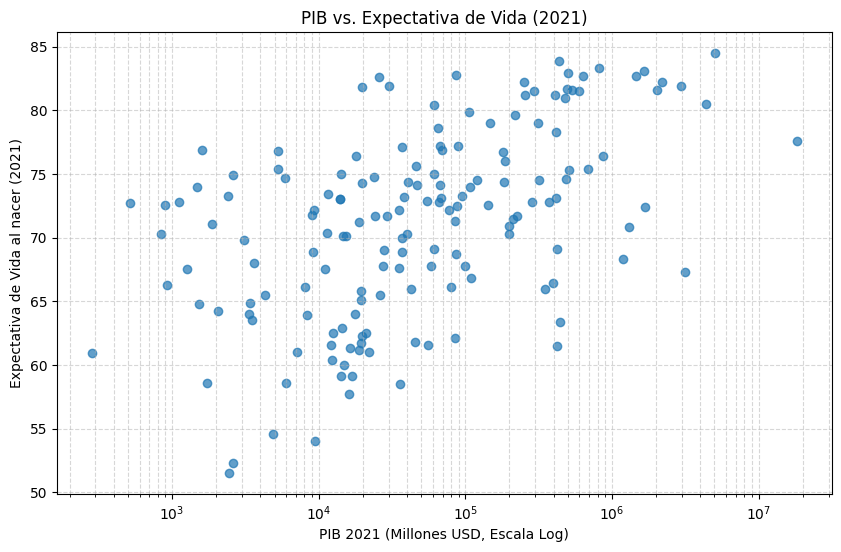

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Usamos plt.scatter para el gráfico de dispersión
plt.scatter(merged_df['GDP_2021'], merged_df['Life_Expectancy'], alpha=0.7)

# Aplicamos la escala logarítmica al eje X
plt.xscale('log')

plt.title('PIB vs. Expectativa de Vida (2021)')
plt.xlabel('PIB 2021 (Millones USD, Escala Log)')
plt.ylabel('Expectativa de Vida al nacer (2021)')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# Guardar la figura
plt.savefig("matplotlib_scatter_gdp_life.png")
plt.clf() # Limpiar figura

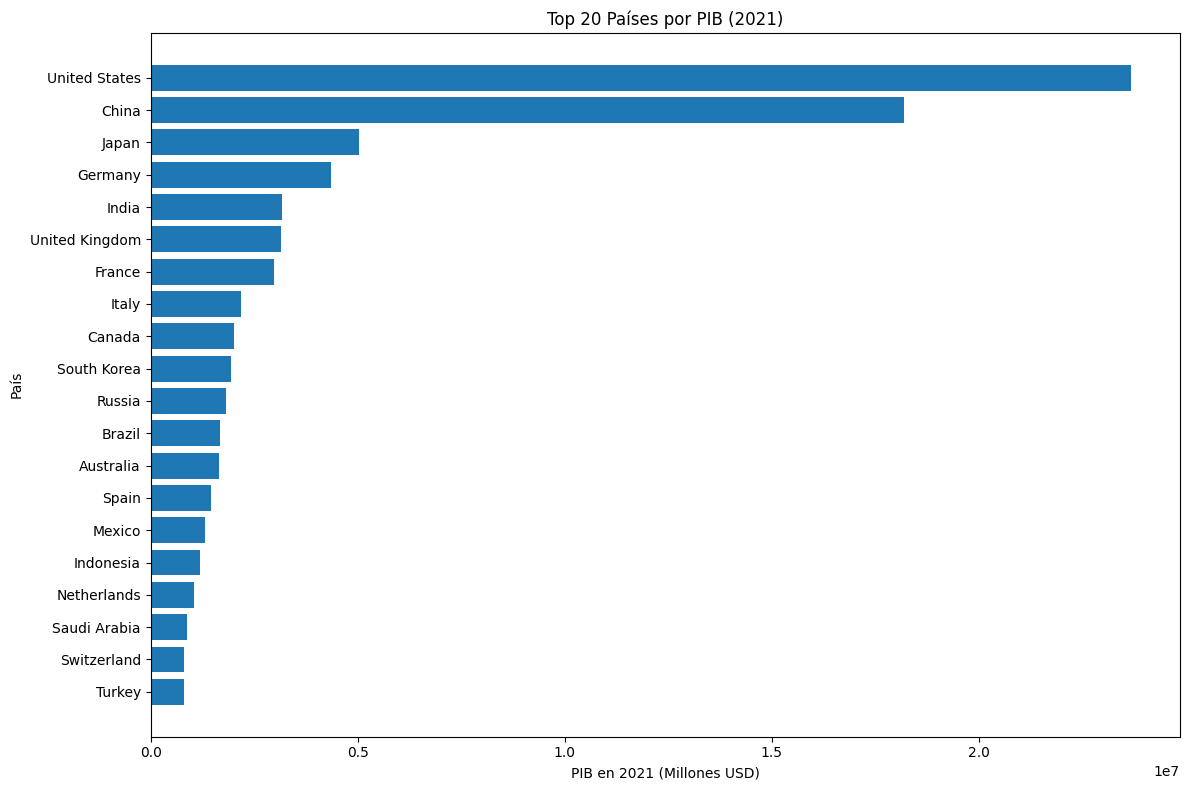

<Figure size 640x480 with 0 Axes>

In [11]:
# Obtener y ordenar los 20 países con mayor PIB
# Matplotlib grafica en el orden dado, así que ordenamos ascendentemente
# para que el más grande quede arriba en el gráfico horizontal.
gdp_top_20 = gdp_2021.nlargest(20, 'GDP_2021').sort_values('GDP_2021', ascending=True)

plt.figure(figsize=(12, 8))
# Usamos plt.barh para un gráfico de barras horizontal
plt.barh(gdp_top_20['Country'], gdp_top_20['GDP_2021'])

plt.title('Top 20 Países por PIB (2021)')
plt.xlabel('PIB en 2021 (Millones USD)')
plt.ylabel('País')
plt.tight_layout() # Asegura que las etiquetas no se corten
plt.show()

plt.savefig("matplotlib_barchart_top20_gdp.png")
plt.clf()

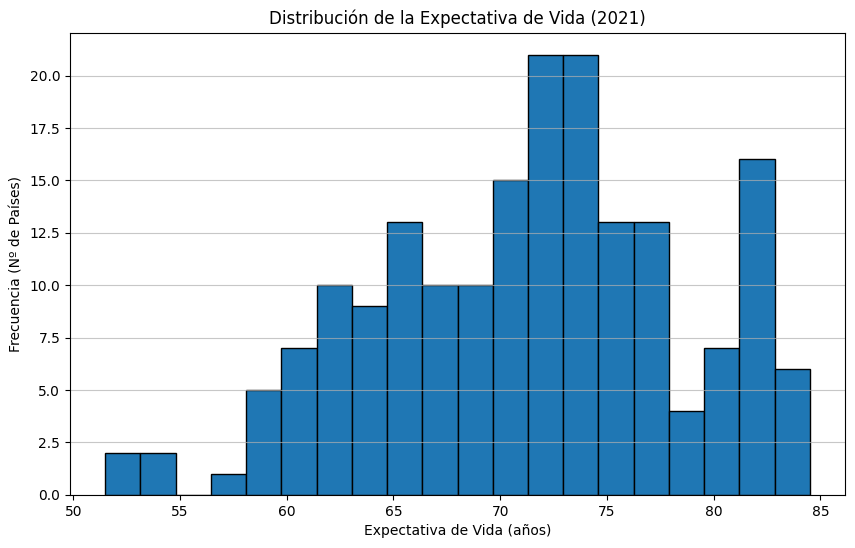

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(10, 6))
# Usamos plt.hist para el histograma
plt.hist(life_exp_2021['Life_Expectancy'], bins=20, edgecolor='black')

plt.title('Distribución de la Expectativa de Vida (2021)')
plt.xlabel('Expectativa de Vida (años)')
plt.ylabel('Frecuencia (Nº de Países)')
plt.grid(axis='y', alpha=0.7)
plt.show()

plt.savefig("matplotlib_histogram_life_exp.png")
plt.clf()

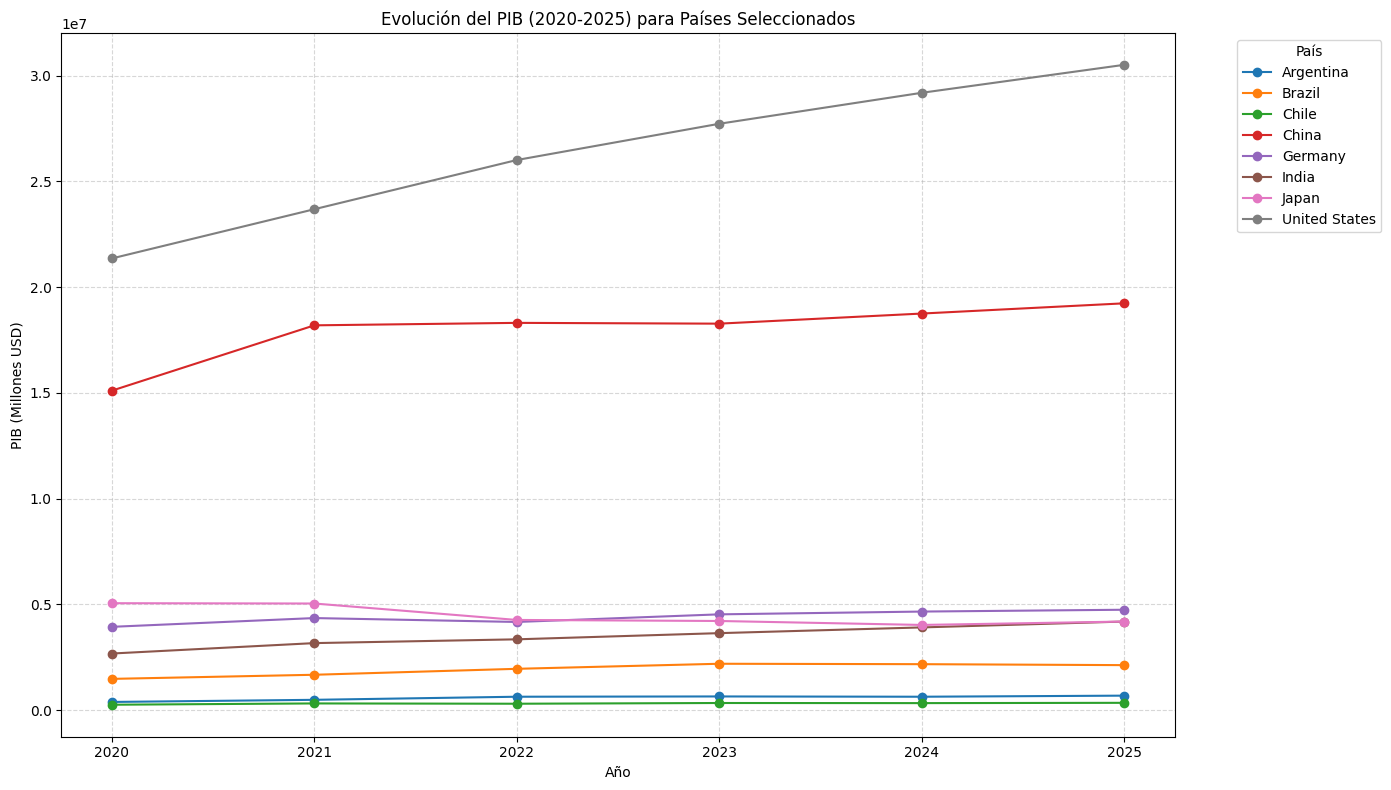

<Figure size 640x480 with 0 Axes>

In [14]:
# --- Preparar datos (melt) ---
year_cols = ['2020', '2021', '2022', '2023', '2024', '2025']
for col in year_cols:
    pib_df[col] = pd.to_numeric(pib_df[col], errors='coerce')
    
pib_melted = pib_df.melt(id_vars=['Country'], value_vars=year_cols, var_name='Year', value_name='GDP')
pib_melted = pib_melted.dropna()
pib_melted['Year'] = pib_melted['Year'].astype(str)

# --- Seleccionar países y pivotear ---
countries_to_plot = ['United States', 'China', 'Germany', 'Japan', 'India', 'Brazil', 'Argentina', 'Chile']
pib_filtered_melted = pib_melted[pib_melted['Country'].isin(countries_to_plot)]

# Pivotear la tabla: Años como filas (index), Países como columnas
pib_pivot = pib_filtered_melted.pivot_table(index='Year', columns='Country', values='GDP')

# --- Graficar ---
# Usar el .plot() integrado de Pandas (que usa Matplotlib)
ax = pib_pivot.plot(kind='line', marker='o', figsize=(14, 8))

plt.title('Evolución del PIB (2020-2025) para Países Seleccionados')
plt.xlabel('Año')
plt.ylabel('PIB (Millones USD)')
# Mover la leyenda fuera del área del gráfico
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

plt.savefig("matplotlib_lineplot_gdp_trends.png")
plt.clf()

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

# --- 1.1 Cargar y "derretir" (melt) datos del PIB ---
pib_df = pd.read_csv("data_2025/pib2020-2025.csv")
year_cols = ['2020', '2021', '2022', '2023', '2024', '2025']
for col in year_cols:
    pib_df[col] = pd.to_numeric(pib_df[col], errors='coerce')
    
pib_melted = pib_df.melt(id_vars=['Country'], value_vars=year_cols, var_name='Year', value_name='GDP')
pib_melted['Year'] = pd.to_numeric(pib_melted['Year'])
pib_melted = pib_melted.dropna(subset=['GDP'])

# --- 1.2 Cargar y limpiar datos de Expectativa de Vida (TODOS los años) ---
who_df = pd.read_csv("data_2025/WHO_life_expectancy.csv")
who_df['Life_Expectancy'] = who_df['Value'].astype(str).str.extract(r"(\d+\.?\d*)").astype(float)
who_df_filtered = who_df[
    (who_df['Indicator'] == 'Life expectancy at birth (years)') &
    (who_df['Dim1'] == 'Both sexes')
]
life_exp_all_years = who_df_filtered[['Location', 'Period', 'Life_Expectancy']].rename(
    columns={'Location': 'Country', 'Period': 'Year'}
).dropna()

# --- 2. Unir y ejecutar regresión ---
# 'how='inner'' asegura que solo tomemos años donde AMBOS tienen datos
merged_all_years_df = pd.merge(pib_melted, life_exp_all_years, on=['Country', 'Year'], how='inner')

# Filtrar GDP > 0 para logaritmo
valid_data_all_years = merged_all_years_df[merged_all_years_df['GDP'] > 0].copy()

if not valid_data_all_years.empty:
    X_all = valid_data_all_years[['GDP']]
    y_all = valid_data_all_years['Life_Expectancy']
    X_log_all = np.log(X_all)

    # --- 2.1 Regresión Lineal ---
    lin_reg_all = LinearRegression()
    lin_reg_all.fit(X_log_all, y_all)
    y_pred_lin_all = lin_reg_all.predict(X_log_all)
    lin_r2_all = r2_score(y_all, y_pred_lin_all)
    print(f"Regresión Lineal (Todos los Años): R²: {lin_r2_all:.3f}")

    # --- 2.2 Regresión Polinomial ---
    poly_features_all = PolynomialFeatures(degree=3, include_bias=False)
    X_poly_all = poly_features_all.fit_transform(X_log_all)
    poly_reg_all = LinearRegression()
    poly_reg_all.fit(X_poly_all, y_all)
    y_pred_poly_all = poly_reg_all.predict(X_poly_all)
    poly_r2_all = r2_score(y_all, y_pred_poly_all)
    print(f"Regresión Polinomial Grado 3 (Todos los Años): R²: {poly_r2_all:.3f}")

    # --- 2.3 Visualización ---
    plt.figure(figsize=(12, 7))
    # Colorear los puntos por año
    scatter = plt.scatter(X_all, y_all, alpha=0.6, c=valid_data_all_years['Year'], cmap='viridis', label='Datos (País-Año)')
    plt.colorbar(scatter, label='Año')
    plt.xscale('log')
    
    
    # ... (código para trazar las líneas de regresión) ...
    
    plt.title('Regresión (PIB vs. Exp. de Vida) - Datos Históricos')
    plt.xlabel('PIB (Millones USD, Escala Log)')
    plt.ylabel('Expectativa de Vida')
    plt.legend()
    
    plt.savefig('regression_gdp_life_exp_all_years.png')
    plt.clf()

Regresión Lineal (Todos los Años): R²: 0.256
Regresión Polinomial Grado 3 (Todos los Años): R²: 0.288


<Figure size 1200x700 with 0 Axes>

In [23]:
# --- 3.1 Proyección del PIB ---

# Años a predecir
years_to_project = np.array(range(2026, 2031)).reshape(-1, 1)
all_gdp_projections = []

# Iterar sobre cada país
for country, group_data in pib_melted.groupby('Country'):
    if len(group_data) < 2: # Necesitamos al menos 2 puntos
        continue
        
    # Preparar datos para este país (X=Año, y=PIB)
    X_time = group_data[['Year']]
    y_time = group_data['GDP']
    
    # Entrenar modelo
    time_reg = LinearRegression()
    time_reg.fit(X_time, y_time)
    
    # Predecir
    gdp_projection = time_reg.predict(years_to_project)
    
    # Guardar resultados
    for i, year in enumerate(years_to_project.flatten()):
        all_gdp_projections.append({
            'Country': country,
            'Year': year,
            'GDP_Projected': gdp_projection[i]
        })

# Convertir la lista de resultados en un DataFrame y guardar
projections_df_gdp = pd.DataFrame(all_gdp_projections)
projections_df_gdp.to_csv('gdp_projections_2026-2030.csv', index=False)

# (El código para la proyección de Expectativa de Vida sigue la misma lógica)

c:\Users\gasxd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\gasxd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\gasxd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\gasxd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\gasxd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py

In [24]:
# --- 3.1 Proyección del PIB ---

# Años a predecir
years_to_project = np.array(range(2026, 2031)).reshape(-1, 1)
all_gdp_projections = []

# Iterar sobre cada país
for country, group_data in pib_melted.groupby('Country'):
    if len(group_data) < 2: # Necesitamos al menos 2 puntos
        continue
        
    # Preparar datos para este país (X=Año, y=PIB)
    X_time = group_data[['Year']]
    y_time = group_data['GDP']
    
    # Entrenar modelo
    time_reg = LinearRegression()
    time_reg.fit(X_time, y_time)
    
    # Predecir
    gdp_projection = time_reg.predict(years_to_project)
    
    # Guardar resultados
    for i, year in enumerate(years_to_project.flatten()):
        all_gdp_projections.append({
            'Country': country,
            'Year': year,
            'GDP_Projected': gdp_projection[i]
        })

# Convertir la lista de resultados en un DataFrame y guardar
projections_df_gdp = pd.DataFrame(all_gdp_projections)
projections_df_gdp.to_csv('gdp_projections_2026-2030.csv', index=False)

# (El código para la proyección de Expectativa de Vida sigue la misma lógica)

c:\Users\gasxd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\gasxd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\gasxd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\gasxd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\gasxd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py

Iniciando la generación del gráfico de fronteras de decisión k-NN...

--- 1. Cargando y preparando datos ---
Datos listos. Clases (Continentes) encontradas: ['Eastern Mediterranean' 'Europe' 'Africa' 'Americas' 'Western Pacific'
 'South-East Asia']

--- 2. Preparando el modelo k-NN ---

--- 3. Entrenando k-NN y generando la malla de decisión ---

--- 4. Generando el gráfico ---


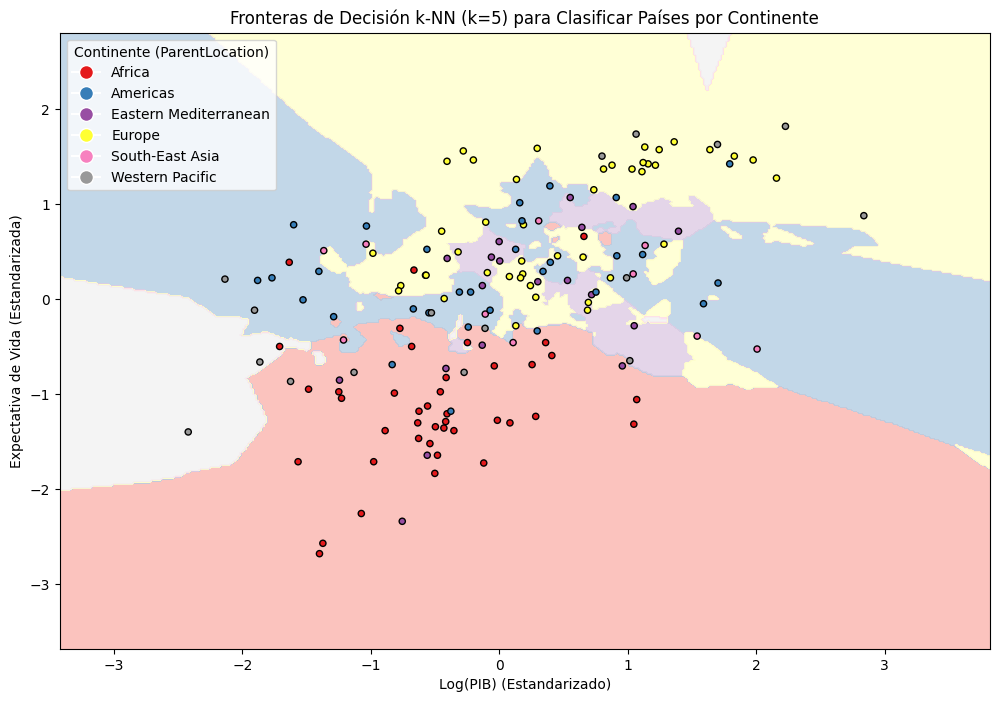

Gráfico k-NN guardado en 'knn_decision_boundary.png'


<Figure size 640x480 with 0 Axes>

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from matplotlib.colors import ListedColormap

print("Iniciando la generación del gráfico de fronteras de decisión k-NN...")

try:
    # --- Tarea 1: Carga y Preparación de Datos para Clasificación ---
    print("\n--- 1. Cargando y preparando datos ---")
    
    # 1.1 Cargar y limpiar datos del PIB (PIB)
    pib_df = pd.read_csv("data_2025/pib2020-2025.csv")
    pib_df['2021_numeric'] = pd.to_numeric(pib_df['2021'], errors='coerce')
    gdp_2021 = pib_df[['Country', '2021_numeric']].rename(columns={'2021_numeric': 'GDP_2021'})
    gdp_2021 = gdp_2021.dropna()

    # 1.2 Cargar y limpiar datos de Expectativa de Vida (WHO)
    # Esta vez, también extraeremos 'ParentLocation' (el continente)
    who_df = pd.read_csv("data_2025/WHO_life_expectancy.csv")
    who_df['Life_Expectancy'] = who_df['Value'].astype(str).str.extract(r"(\d+\.?\d*)").astype(float)
    
    who_df_filtered = who_df[
        (who_df['Indicator'] == 'Life expectancy at birth (years)') &
        (who_df['Dim1'] == 'Both sexes') &
        (who_df['Period'] == 2021)
    ]
    
    # Seleccionamos las columnas que necesitamos, incluyendo 'ParentLocation'
    who_data_2021 = who_df_filtered[['Location', 'Life_Expectancy', 'ParentLocation']].rename(columns={'Location': 'Country'})
    who_data_2021 = who_data_2021.dropna()

    # 1.3 Unir los DataFrames
    merged_df = pd.merge(gdp_2021, who_data_2021, on='Country', how='inner')
    
    # Filtrar GDP > 0 para poder aplicar el logaritmo
    merged_df = merged_df[merged_df['GDP_2021'] > 0]
    # Usamos Log(PIB) como feature, ya que está mejor distribuido
    merged_df['Log_GDP'] = np.log(merged_df['GDP_2021'])
    
    # DataFrame final para el modelo
    final_data = merged_df[['Log_GDP', 'Life_Expectancy', 'ParentLocation']].dropna()
    print(f"Datos listos. Clases (Continentes) encontradas: {final_data['ParentLocation'].unique()}")

    # --- Tarea 2: Preparación del Modelo k-NN ---
    print("\n--- 2. Preparando el modelo k-NN ---")
    
    # X: Features (Características). Usamos Log(PIB) y Exp. de Vida
    X = final_data[['Log_GDP', 'Life_Expectancy']]
    
    # y: Target (Clase). Usamos el Continente
    y_labels = final_data['ParentLocation']
    
    # k-NN necesita que las clases 'y' sean numéricas (0, 1, 2...)
    le = LabelEncoder()
    y = le.fit_transform(y_labels)
    
    # Es crucial estandarizar (escalar) las features para k-NN
    # Esto asegura que Log(PIB) y Exp. de Vida tengan la misma importancia
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # --- Tarea 3: Entrenamiento del Modelo y Creación de la Malla ---
    print("\n--- 3. Entrenando k-NN y generando la malla de decisión ---")
    
    # Definimos k (número de vecinos)
    k = 5
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_scaled, y)
    
    # Crear una malla de puntos para graficar las fronteras
    h = .02 # tamaño de la celda de la malla
    x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
    y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predecir la clase para cada punto en la malla
    # np.c_ toma las mallas xx e yy y las convierte en pares de coordenadas
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # --- Tarea 4: Generación del Gráfico ---
    print("\n--- 4. Generando el gráfico ---")
    
    # Crear mapas de colores
    num_classes = len(le.classes_)
    cmap_light = plt.get_cmap('Pastel1', num_classes) # Colores para las regiones
    cmap_bold = plt.get_cmap('Set1', num_classes)     # Colores para los puntos

    plt.figure(figsize=(12, 8))
    
    # Dibujar las regiones de decisión (el fondo coloreado)
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
    
    # Dibujar los puntos de datos reales
    scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=cmap_bold,
                              edgecolor='k', s=20)
    
    plt.title(f'Fronteras de Decisión k-NN (k={k}) para Clasificar Países por Continente')
    plt.xlabel('Log(PIB) (Estandarizado)')
    plt.ylabel('Expectativa de Vida (Estandarizada)')
    
    # Crear una leyenda personalizada
    handles = []
    for i, class_name in enumerate(le.classes_):
        handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor=cmap_bold.colors[i], markersize=10,
                                  label=class_name))
        
    plt.legend(handles=handles, title="Continente (ParentLocation)")
    plt.show()
    
    # Guardar el gráfico
    plt.savefig('knn_decision_boundary.png')
    print("Gráfico k-NN guardado en 'knn_decision_boundary.png'")
    plt.clf()

except Exception as e:
    print(f"Ocurrió un error: {e}")